In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### MATH 189 Final Project

#### Import the Data

In [3]:
pl_2018 = pd.read_csv('data/PL_2018_2019.csv')
pl_2019 = pd.read_csv('data/PL_2019_2020.csv')
pl_2023 = pd.read_csv('data/PL_2023_2024.csv')

#### Column Keys

#### Exploratory Data Analysis

In [9]:
pl_2018.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [10]:
pl_2019.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


In [11]:
pl_2023.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


General Dataset Cleanup

In [53]:
# the columns related to betting data - look at notes.txt for more info
columns_to_keep = [
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam',
    'FTHG', 'HG', 'FTAG', 'AG', 'FTR', 'Res',
    'HTHG', 'HTAG', 'HTR',
    'Attendance', 'Referee',
    'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC',
    'HO', 'AO', 'HY', 'AY', 'HR', 'AR',
    'HBP', 'ABP'
]

pl_2018 = pl_2018[[col for col in columns_to_keep if col in pl_2018.columns]]
pl_2019 = pl_2019[[col for col in columns_to_keep if col in pl_2019.columns]]
pl_2023 = pl_2023[[col for col in columns_to_keep if col in pl_2023.columns]]

rename_columns = {
    'Div': 'LeagueDivision',
    'Date': 'MatchDate',
    'Time': 'KickoffTime',
    'HomeTeam': 'HomeTeam',
    'AwayTeam': 'AwayTeam',
    'FTHG': 'FullTimeHomeGoals',
    'FTAG': 'FullTimeAwayGoals',
    'FTR': 'FullTimeResult',
    'HTHG': 'HalfTimeHomeGoals',
    'HTAG': 'HalfTimeAwayGoals',
    'HTR': 'HalfTimeResult',
    'Attendance': 'Attendance',
    'Referee': 'Referee',
    'HS': 'HomeShots',
    'AS': 'AwayShots',
    'HST': 'HomeShotsOnTarget',
    'AST': 'AwayShotsOnTarget',
    'HHW': 'HomeHitWoodwork',
    'AHW': 'AwayHitWoodwork',
    'HC': 'HomeCorners',
    'AC': 'AwayCorners',
    'HF': 'HomeFouls',
    'AF': 'AwayFouls',
    'HFKC': 'HomeFreeKicksConceded',
    'AFKC': 'AwayFreeKicksConceded',
    'HO': 'HomeOffsides',
    'AO': 'AwayOffsides',
    'HY': 'HomeYellowCards',
    'AY': 'AwayYellowCards',
    'HR': 'HomeRedCards',
    'AR': 'AwayRedCards',
    'HBP': 'HomeBookingPoints',
    'ABP': 'AwayBookingPoints'
}

pl_2018.rename(columns=rename_columns, inplace=True)
pl_2019.rename(columns=rename_columns, inplace=True)
pl_2023.rename(columns=rename_columns, inplace=True)

Find any missing values

In [54]:
print(f'Null values in pl_2018 dataset: {pl_2018.isna().sum().sum()}')
print(f'Null values in pl_2019 dataset: {pl_2019.isna().sum().sum()}')
print(f'Null values in pl_2023 dataset: {pl_2023.isna().sum().sum()}')

Null values in pl_2018 dataset: 0
Null values in pl_2019 dataset: 0
Null values in pl_2023 dataset: 0


Convert the corresponding variables to categorical

In [67]:
categorical_cols = [
    'LeagueDivision',
    'HomeTeam',
    'AwayTeam',
    'FullTimeResult',
    'HalfTimeResult',
    'Referee'
]

for col in categorical_cols:
    if col in pl_2018.columns:
        pl_2018[col] = pl_2018[col].astype('category')
    if col in pl_2019.columns:
        pl_2019[col] = pl_2019[col].astype('category')
    if col in pl_2023.columns:
        pl_2023[col] = pl_2023[col].astype('category')

Dataset Description

In [99]:
pl_2018.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.568421,1.252632,0.678947,0.573684,14.134211,11.144737,4.778947,3.928947,5.705263,4.552632,10.152632,10.305263,1.526316,1.684211,0.047368,0.076316
std,1.312836,1.180031,0.860802,0.766958,5.855371,4.654002,2.677686,2.283982,2.971718,2.730627,3.293532,3.503707,1.222844,1.209140,0.212706,0.275599
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,4.000000,2.750000,8.000000,8.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,14.000000,11.000000,5.000000,4.000000,5.000000,4.000000,10.000000,10.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,18.000000,14.000000,6.000000,5.250000,8.000000,6.000000,12.000000,13.000000,2.000000,2.000000,0.000000,0.000000
max,6.000000,6.000000,4.000000,3.000000,36.000000,25.000000,14.000000,12.000000,16.000000,14.000000,23.000000,21.000000,6.000000,5.000000,1.000000,2.000000


In [100]:
pl_2019.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.515789,1.205263,0.700000,0.550000,13.323684,11.400000,4.555263,3.994737,5.773684,4.931579,10.484211,10.981579,1.586842,1.765789,0.057895,0.060526
std,1.248646,1.200252,0.886427,0.758505,5.417938,5.255278,2.520543,2.489020,3.217095,2.835052,3.582759,3.713653,1.241471,1.217891,0.244875,0.238774
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,3.000000,3.000000,8.000000,8.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,4.000000,4.000000,5.000000,5.000000,10.000000,11.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,16.000000,14.000000,6.000000,5.000000,8.000000,7.000000,13.000000,13.000000,2.000000,3.000000,0.000000,0.000000
max,8.000000,9.000000,5.000000,5.000000,31.000000,26.000000,13.000000,15.000000,17.000000,16.000000,23.000000,24.000000,6.000000,6.000000,2.000000,1.000000


In [101]:
pl_2023.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.800000,1.478947,0.734211,0.626316,15.402632,12.181579,5.436842,4.431579,6.123684,4.713158,10.744737,11.347368,1.910526,2.263158,0.068421,0.081579
std,1.365616,1.277811,0.831687,0.823367,6.261959,5.467696,2.885449,2.526493,3.221460,2.906518,3.457331,3.674826,1.392553,1.389448,0.263030,0.283546
min,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,11.000000,8.000000,3.000000,3.000000,4.000000,3.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,0.000000,15.000000,11.000000,5.000000,4.000000,6.000000,4.000000,11.000000,11.000000,2.000000,2.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,19.000000,15.000000,7.000000,6.000000,8.000000,6.000000,13.000000,14.000000,3.000000,3.000000,0.000000,0.000000
max,6.000000,8.000000,4.000000,5.000000,36.000000,30.000000,15.000000,15.000000,17.000000,15.000000,20.000000,22.000000,6.000000,7.000000,2.000000,2.000000


Referee EDA

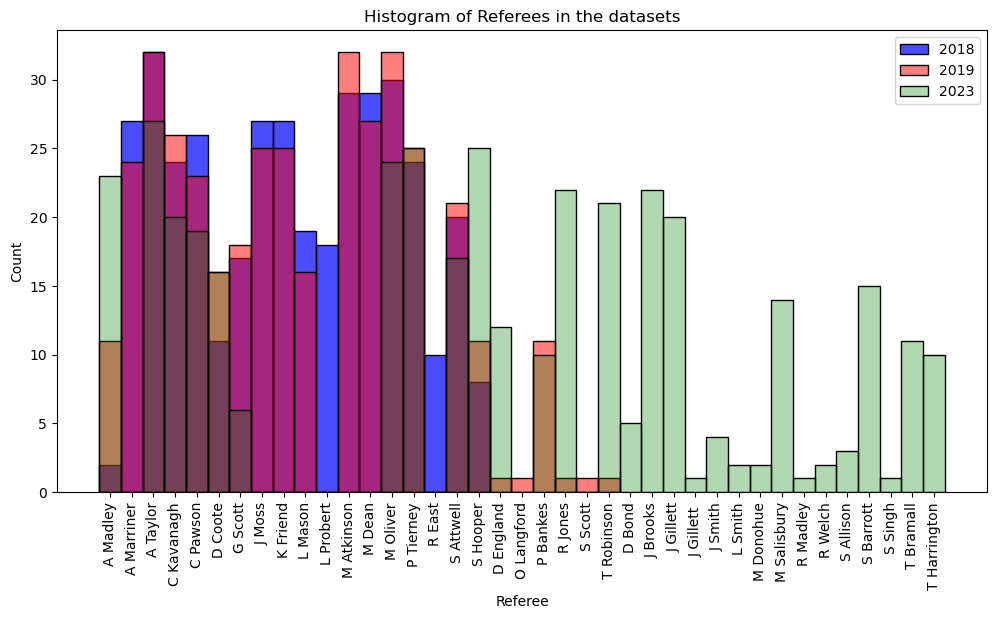

Referee with the most matches in 2018 dataset: A Taylor
Referee with the most matches in 2019 dataset: M Atkinson
Referee with the most matches in 2023 dataset: A Taylor


In [ ]:
# plot the histogram of all the refrees in the datasets
plt.figure(figsize=(12, 6))
sns.histplot(pl_2018['Referee'], kde=False, color='blue', alpha=0.7)
sns.histplot(pl_2019['Referee'], kde=False, color='red', alpha=0.5)
sns.histplot(pl_2023['Referee'], kde=False, color='green', alpha=0.3)
plt.xticks(rotation=90)
plt.legend(['2018', '2019', '2023'])
plt.title('Histogram of Referees in the datasets')
plt.show()

# refree with the most matches in the datasets
most_matches_2018 = pl_2018['Referee'].value_counts().idxmax()
most_matches_2019 = pl_2019['Referee'].value_counts().idxmax()
most_matches_2023 = pl_2023['Referee'].value_counts().idxmax()

print(f'Referee with the most matches in 2018 dataset: {most_matches_2018}')
print(f'Referee with the most matches in 2019 dataset: {most_matches_2019}')
print(f'Referee with the most matches in 2023 dataset: {most_matches_2023}')


Match Results EDA

Text(0.5, 1.0, 'Histogram of Full Time Results in the datasets')

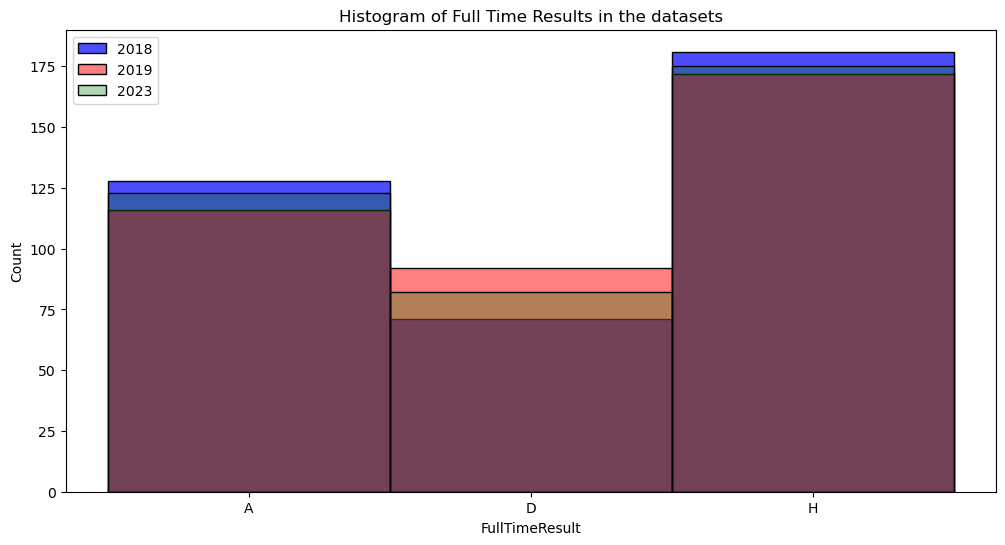

In [92]:
# plot the histogram of full time results in the datasets
plt.figure(figsize=(12, 6))
sns.histplot(pl_2018['FullTimeResult'], kde=False, color='blue', alpha=0.7)
sns.histplot(pl_2019['FullTimeResult'], kde=False, color='red', alpha=0.5)
sns.histplot(pl_2023['FullTimeResult'], kde=False, color='green', alpha=0.3)
plt.legend(['2018', '2019', '2023'])
plt.title('Histogram of Full Time Results in the datasets')


Home and Away Fouls EDA

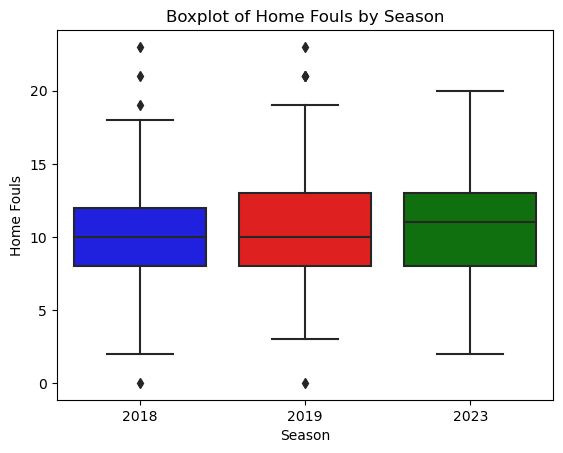

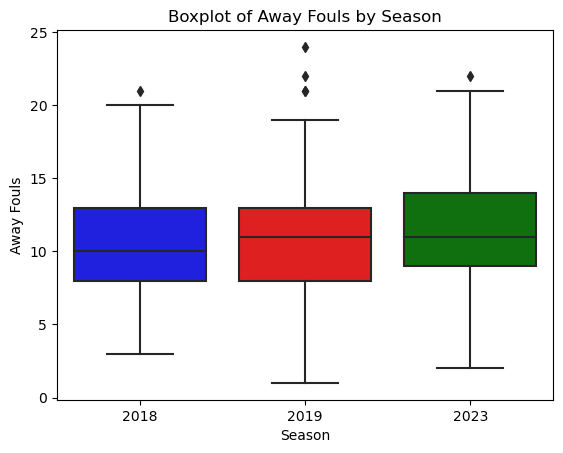

In [98]:
pl_2018['Season'] = '2018'
pl_2019['Season'] = '2019'
pl_2023['Season'] = '2023'

combined_df = pd.concat([pl_2018, pl_2019, pl_2023])

sns.boxplot(x='Season', y='HomeFouls', data=combined_df, palette=['blue', 'red', 'green'])

plt.title('Boxplot of Home Fouls by Season')
plt.xlabel('Season')
plt.ylabel('Home Fouls')
plt.show()

sns.boxplot(x='Season', y='AwayFouls', data=combined_df, palette=['blue', 'red', 'green'])
plt.title('Boxplot of Away Fouls by Season')
plt.xlabel('Season')
plt.ylabel('Away Fouls')
plt.show()



Bookings EDA

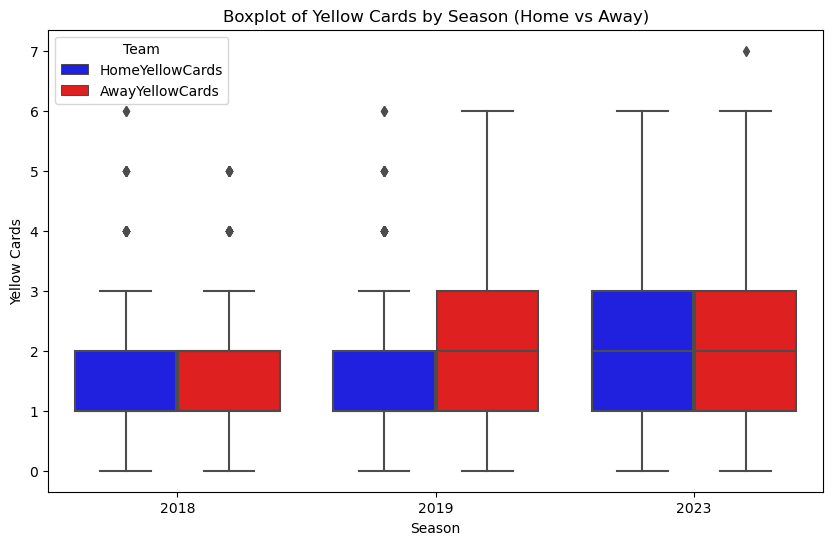

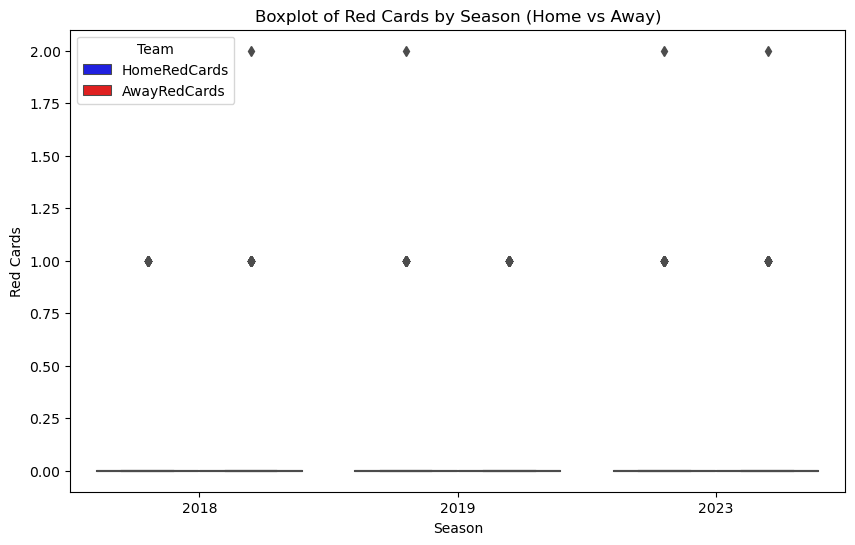

In [108]:
yellow_cards_df = combined_df.melt(
    id_vars=['Season'],
    value_vars=['HomeYellowCards', 'AwayYellowCards'],
    var_name='TeamType',
    value_name='YellowCards'
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Season',
    y='YellowCards',
    hue='TeamType',
    data=yellow_cards_df,
    palette={'HomeYellowCards': 'blue', 'AwayYellowCards': 'red'}
)

plt.title('Boxplot of Yellow Cards by Season (Home vs Away)')
plt.xlabel('Season')
plt.ylabel('Yellow Cards')
plt.legend(title='Team')
plt.show()

red_cards_df = combined_df.melt(
    id_vars=['Season'],
    value_vars=['HomeRedCards', 'AwayRedCards'],
    var_name='TeamType',
    value_name='RedCards'
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Season',
    y='RedCards',
    hue='TeamType',
    data=red_cards_df,
    palette={'HomeRedCards': 'blue', 'AwayRedCards': 'red'}
)

plt.title('Boxplot of Red Cards by Season (Home vs Away)')
plt.xlabel('Season')
plt.ylabel('Red Cards')
plt.legend(title='Team')
plt.show()